In [47]:
import sys
from pathlib import Path
from string import ascii_lowercase, ascii_uppercase

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

# from matplotlib import cbook
from mpl_toolkits.axes_grid1 import AxesGrid
from scipy import stats

# Constants

In [222]:
xr.set_options(keep_attrs=True)
infile_path = Path("/sto0/data/Intermediate/Hunga_Tonga_byAles/ht/")
plt.rcParams.update(
    {
        "font.size": 25,
        "xtick.labelsize": 16,
        "ytick.labelsize": 16,
    }
)

# Functions

In [96]:
def process(ds, deseasonalize=True, upper_limit=0.1, lower_limit=300):
    ds = ds.drop_vars(["var152", "time_bnds", "lat_bnds"], errors="ignore")
    ds["time"] = pd.date_range("2021-01", freq="M", periods=ds.time.shape[0])
    ds["plev"] = ds.plev.values / 100.0
    ds["plev"].attrs["units"] = "hPa"
    ds["plev"].attrs["long_name"] = "pressure"
    ds["plev"].attrs["standard_name"] = "pressure"

    if deseasonalize:
        ds = anomalize_func(ds)  # deseasonalize_func(ds)

    return ds.sel(plev=slice(upper_limit, lower_limit))


def process_tpp(ds, deseasonalize=True, upper_limit=1, lower_limit=300):
    ds = ds.drop_vars(["var152", "time_bnds", "lat_bnds"], errors="ignore")
    ds["time"] = pd.date_range("2021-01", freq="M", periods=ds.time.shape[0])
    ds = ds.rename({"var237": "tpp"})
    ds["tpp"] = ds["tpp"] / 100.0

    ds["tpp"].attrs["units"] = "hPa"
    ds["tpp"].attrs["long_name"] = "tropopause pressure"
    # ds["plev"].attrs["standard_name"] = "pressure"

    if deseasonalize:
        ds = anomalize_func(ds)  # deseasonalize_func(ds)

    return ds


def xr_multipletest(p, alpha=0.05, method="fdr_bh", **multipletests_kwargs):
    """Apply statsmodels.stats.multitest.multipletests for multi-dimensional xr.objects."""
    from statsmodels.stats.multitest import multipletests

    # stack all to 1d array
    p_stacked = p.stack(s=p.dims)
    # mask only where not nan: https://github.com/statsmodels/statsmodels/issues/2899
    mask = np.isfinite(p_stacked)
    pvals_corrected = np.full(p_stacked.shape, np.nan)
    reject = np.full(p_stacked.shape, np.nan)
    # apply test where mask
    reject[mask] = multipletests(
        p_stacked[mask], alpha=alpha, method=method, **multipletests_kwargs
    )[0]
    pvals_corrected[mask] = multipletests(
        p_stacked[mask], alpha=alpha, method=method, **multipletests_kwargs
    )[1]

    def unstack(reject, p_stacked):
        """Exchange values from p_stacked with reject (1d array) and unstack."""
        xreject = p_stacked.copy()
        xreject.values = reject
        xreject = xreject.unstack()
        return xreject

    reject = unstack(reject, p_stacked)
    pvals_corrected = unstack(pvals_corrected, p_stacked)
    return reject, pvals_corrected

In [20]:
from dask.distributed import LocalCluster

# https://forum.access-hive.org.au/t/netcdf-not-a-valid-id-errors/389/12
cluster = LocalCluster(threads_per_worker=1)  # Fully-featured local Dask cluster
client = cluster.get_client()
client

/hpx/Data_impb/kales/conda/envs/myenv/lib/python3.11/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 44983 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:44983/status,
Dashboard: http://127.0.0.1:44983/status,Workers: 56
Total threads: 56,Total memory: 755.75 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35471,Workers: 56
Dashboard: http://127.0.0.1:44983/status,Total threads: 56
Started: Just now,Total memory: 755.75 GiB
Comm: tcp://127.0.0.1:38969,Total threads: 1
Dashboard: http://127.0.0.1:38029/status,Memory: 13.50 GiB
Nanny: tcp://127.0.0.1:44149,


# Load dataset

## tropopause

In [19]:
what = "tropopause"
infiles_w = sorted(infile_path.glob(f"socol4_htt1?_{what}_*"))
infiles_wo = sorted(infile_path.glob(f"socol4_htt2?_{what}_*"))

In [21]:
ds_w_tpp = (
    xr.open_mfdataset(
        infiles_w,
        parallel=True,  #  will be performed in parallel using dask.delayed
        combine="nested",
        concat_dim=["ens"],
    )
    .pipe(process_tpp, deseasonalize=False)
    .load()
)
ds_w_tpp

/tmp/ipykernel_1689378/152642432.py:17: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ds["time"] = pd.date_range("2021-01", freq="M", periods=ds.time.shape[0])


<xarray.Dataset>
Dimensions:  (time: 60, lon: 192, lat: 96, ens: 10)
Coordinates:
  * time     (time) datetime64[ns] 2021-01-31 2021-02-28 ... 2025-12-31
  * lon      (lon) float64 0.0 1.875 3.75 5.625 7.5 ... 352.5 354.4 356.2 358.1
  * lat      (lat) float64 88.57 86.72 84.86 83.0 ... -83.0 -84.86 -86.72 -88.57
Dimensions without coordinates: ens
Data variables:
    tpp      (ens, time, lat, lon) float32 254.9 254.9 254.9 ... 201.6 201.6
Attributes:
    CDI:          Climate Data Interface version 1.9.10 (https://mpimet.mpg.d...
    Conventions:  CF-1.6
    institution:  Max Planck Institute for Meteorology
    history:      Thu Mar 21 18:04:20 2024: cdo cat ttsocol4_htt1011.nc /scra...
    frequency:    mon
    CDO:          Climate Data Operators version 1.9.10 (https://mpimet.mpg.d...

In [22]:
ds_wo_tpp = (
    xr.open_mfdataset(
        infiles_wo,
        parallel=True,  #  will be performed in parallel using dask.delayed
        combine="nested",
        concat_dim=["ens"],
    )
    .pipe(process_tpp, deseasonalize=False)
    .load()
)
ds_wo_tpp

/tmp/ipykernel_1689378/152642432.py:17: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ds["time"] = pd.date_range("2021-01", freq="M", periods=ds.time.shape[0])


<xarray.Dataset>
Dimensions:  (time: 60, lon: 192, lat: 96, ens: 10)
Coordinates:
  * time     (time) datetime64[ns] 2021-01-31 2021-02-28 ... 2025-12-31
  * lon      (lon) float64 0.0 1.875 3.75 5.625 7.5 ... 352.5 354.4 356.2 358.1
  * lat      (lat) float64 88.57 86.72 84.86 83.0 ... -83.0 -84.86 -86.72 -88.57
Dimensions without coordinates: ens
Data variables:
    tpp      (ens, time, lat, lon) float32 nan nan nan nan ... 246.2 246.3 246.3
Attributes:
    CDI:          Climate Data Interface version 1.9.10 (https://mpimet.mpg.d...
    Conventions:  CF-1.6
    institution:  Max Planck Institute for Meteorology
    history:      Thu Mar 21 18:04:40 2024: cdo cat ttsocol4_htt2011.nc /scra...
    frequency:    mon
    CDO:          Climate Data Operators version 1.9.10 (https://mpimet.mpg.d...

In [25]:
time_slice = slice("2022-12-01", "2023-04-30")
sel_dict = dict(time=time_slice, lat=slice(None, None))
da_w_tpp = ds_w_tpp["tpp"].sel(**sel_dict).mean(["lon", "ens"]).squeeze()

## HOx

In [38]:
what = "OHx_mm_zon"
infiles_w = list(infile_path.glob(f"socol4_htt1*{what}*"))
infiles_wo = list(infile_path.glob(f"socol4_htt2*{what}*"))

In [39]:
ds_w_hox = (
    xr.open_mfdataset(
        infiles_w,
        parallel=True,  #  will be performed in parallel using dask.delayed
        combine="nested",
        concat_dim=["ens"],
    )
    .pipe(process, deseasonalize=False, upper_limit=0.1)
    .load()
)
ds_w_hox

/tmp/ipykernel_1689378/152642432.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ds["time"] = pd.date_range("2021-01", freq="M", periods=ds.time.shape[0])


<xarray.Dataset>
Dimensions:  (time: 60, lon: 1, lat: 96, plev: 26, ens: 10)
Coordinates:
  * time     (time) datetime64[ns] 2021-01-31 2021-02-28 ... 2025-12-31
  * lon      (lon) float64 0.0
  * lat      (lat) float64 88.57 86.72 84.86 83.0 ... -83.0 -84.86 -86.72 -88.57
  * plev     (plev) float64 0.1112 0.2315 0.4259 0.7355 ... 208.7 238.3 270.1
Dimensions without coordinates: ens
Data variables:
    OH_m     (ens, time, plev, lat, lon) float32 2.323e-12 ... 2.807e-13
Attributes:
    CDI:          Climate Data Interface version 1.9.10 (https://mpimet.mpg.d...
    Conventions:  CF-1.6
    history:      Fri Mar 22 14:28:51 2024: cdo cat Postproc_example-OHx-para...
    frequency:    mon
    CDO:          Climate Data Operators version 1.9.10 (https://mpimet.mpg.d...

In [40]:
ds_wo_hox = (
    xr.open_mfdataset(
        infiles_wo,
        parallel=True,  #  will be performed in parallel using dask.delayed
        combine="nested",
        concat_dim=["ens"],
    )
    .pipe(process, deseasonalize=False, upper_limit=0.1)
    .load()
)
ds_wo_hox

/tmp/ipykernel_1689378/152642432.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ds["time"] = pd.date_range("2021-01", freq="M", periods=ds.time.shape[0])


<xarray.Dataset>
Dimensions:  (time: 60, lon: 1, lat: 96, plev: 26, ens: 10)
Coordinates:
  * time     (time) datetime64[ns] 2021-01-31 2021-02-28 ... 2025-12-31
  * lon      (lon) float64 0.0
  * lat      (lat) float64 88.57 86.72 84.86 83.0 ... -83.0 -84.86 -86.72 -88.57
  * plev     (plev) float64 0.1112 0.2315 0.4259 0.7355 ... 208.7 238.3 270.1
Dimensions without coordinates: ens
Data variables:
    OH_m     (ens, time, plev, lat, lon) float32 nan nan ... 2.891e-13 3.056e-13
Attributes:
    CDI:          Climate Data Interface version 1.9.10 (https://mpimet.mpg.d...
    Conventions:  CF-1.6
    history:      Fri Mar 22 14:29:26 2024: cdo cat Postproc_example-OHx-para...
    frequency:    mon
    CDO:          Climate Data Operators version 1.9.10 (https://mpimet.mpg.d...

## Chemistry + dynamics

In [41]:
what = "chem_mm_zon"
infiles_w = list(infile_path.glob(f"socol4_htt1?_{what}*"))
infiles_wo = list(infile_path.glob(f"socol4_htt2?_{what}*"))

In [42]:
infiles_wo

[PosixPath('/sto0/data/Intermediate/Hunga_Tonga_byAles/ht/socol4_htt28_chem_mm_zon_2021-2025.nc'),
 PosixPath('/sto0/data/Intermediate/Hunga_Tonga_byAles/ht/socol4_htt29_chem_mm_zon_2021-2025.nc'),
 PosixPath('/sto0/data/Intermediate/Hunga_Tonga_byAles/ht/socol4_htt24_chem_mm_zon_2021-2025.nc'),
 PosixPath('/sto0/data/Intermediate/Hunga_Tonga_byAles/ht/socol4_htt25_chem_mm_zon_2021-2025.nc'),
 PosixPath('/sto0/data/Intermediate/Hunga_Tonga_byAles/ht/socol4_htt27_chem_mm_zon_2021-2025.nc'),
 PosixPath('/sto0/data/Intermediate/Hunga_Tonga_byAles/ht/socol4_htt26_chem_mm_zon_2021-2025.nc'),
 PosixPath('/sto0/data/Intermediate/Hunga_Tonga_byAles/ht/socol4_htt23_chem_mm_zon_2021-2025.nc'),
 PosixPath('/sto0/data/Intermediate/Hunga_Tonga_byAles/ht/socol4_htt22_chem_mm_zon_2021-2025.nc'),
 PosixPath('/sto0/data/Intermediate/Hunga_Tonga_byAles/ht/socol4_htt20_chem_mm_zon_2021-2025.nc'),
 PosixPath('/sto0/data/Intermediate/Hunga_Tonga_byAles/ht/socol4_htt21_chem_mm_zon_2021-2025.nc')]

In [43]:
ds_wo_chem = (
    xr.open_mfdataset(
        infiles_wo,
        parallel=True,  #  will be performed in parallel using dask.delayed
        combine="nested",
        concat_dim=["ens"],
    )
    .pipe(process, deseasonalize=False, upper_limit=0.01)
    .load()
)
ds_wo_chem

/tmp/ipykernel_1689378/152642432.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ds["time"] = pd.date_range("2021-01", freq="M", periods=ds.time.shape[0])


<xarray.Dataset>
Dimensions:  (time: 60, lon: 1, lat: 96, plev: 27, ens: 10)
Coordinates:
  * time     (time) datetime64[ns] 2021-01-31 2021-02-28 ... 2025-12-31
  * lon      (lon) float64 0.0
  * lat      (lat) float64 88.57 86.72 84.86 83.0 ... -83.0 -84.86 -86.72 -88.57
  * plev     (plev) float64 0.04281 0.1112 0.2315 0.4259 ... 208.7 238.3 270.1
Dimensions without coordinates: ens
Data variables:
    te_m     (ens, time, plev, lat, lon) float32 nan nan nan ... 208.1 208.0
    u_m      (ens, time, plev, lat, lon) float32 nan nan nan ... 5.389 3.692
    O3_m     (ens, time, plev, lat, lon) float32 nan nan ... 7.337e-08 7.298e-08
    H2O_m    (ens, time, plev, lat, lon) float32 nan nan ... 1.944e-05 1.806e-05
Attributes:
    CDI:          Climate Data Interface version 1.9.10 (https://mpimet.mpg.d...
    Conventions:  CF-1.6
    history:      Thu Feb 29 16:07:22 2024: cdo cat ss4.nc /scratch/snx3000/a...
    frequency:    mon
    CDO:          Climate Data Operators version 1.9.10 (https://mpimet.mpg.d...

In [44]:
ds_w_chem = (
    xr.open_mfdataset(
        infiles_w,
        parallel=True,  #  will be performed in parallel using dask.delayed
        combine="nested",
        concat_dim=["ens"],
    )
    .pipe(process, deseasonalize=False, upper_limit=0.01)
    .load()
)
ds_w_chem

/tmp/ipykernel_1689378/152642432.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ds["time"] = pd.date_range("2021-01", freq="M", periods=ds.time.shape[0])


<xarray.Dataset>
Dimensions:  (time: 60, lon: 1, lat: 96, plev: 27, ens: 10)
Coordinates:
  * time     (time) datetime64[ns] 2021-01-31 2021-02-28 ... 2025-12-31
  * lon      (lon) float64 0.0
  * lat      (lat) float64 88.57 86.72 84.86 83.0 ... -83.0 -84.86 -86.72 -88.57
  * plev     (plev) float64 0.04281 0.1112 0.2315 0.4259 ... 208.7 238.3 270.1
Dimensions without coordinates: ens
Data variables:
    te_m     (ens, time, plev, lat, lon) float32 236.8 236.3 ... 212.2 212.3
    u_m      (ens, time, plev, lat, lon) float32 -1.594 -1.359 ... -1.919 -1.554
    O3_m     (ens, time, plev, lat, lon) float32 1.577e-06 ... 8.991e-08
    H2O_m    (ens, time, plev, lat, lon) float32 2.381e-06 ... 3.163e-05
Attributes:
    CDI:          Climate Data Interface version 1.9.10 (https://mpimet.mpg.d...
    Conventions:  CF-1.6
    history:      Tue Mar 12 10:25:13 2024: cdo cat ss4.nc /scratch/snx3000/a...
    frequency:    mon
    CDO:          Climate Data Operators version 1.9.10 (https://mpimet.mpg.d...

# Visualization

In [48]:
data_ls = []
data_pv_ls = []

## H2O

In [49]:
time_slice = slice("2022-12-01", "2023-04-30")
sel_dict = dict(time=time_slice, lat=slice(None, None))
sel_var = "H2O_m"


arr1 = ds_w_chem[sel_var].sel(**sel_dict).squeeze().load()
arr2 = ds_wo_chem[sel_var].sel(**sel_dict).squeeze().load()
diff = ((arr1 - arr2)).mean("ens") * 1e6
# diff["time"] = map_time_str(diff.time)
diff.attrs["units"] = "ppmv"
diff.attrs["long_name"] = r"H$_2$O VMR"


t_stat, p_values = stats.ttest_ind(
    arr1, arr2, equal_var=False
)  # , nan_policy = nan_policy)
diff_pv = xr.DataArray(p_values, coords=diff.coords)

data_ls.append(diff)
data_pv_ls.append(diff_pv)

## O3

In [50]:
time_slice = slice("2022-12-01", "2023-04-30")
sel_dict = dict(time=time_slice, lat=slice(None, None))
sel_var = "O3_m"


arr1 = ds_w_chem[sel_var].sel(**sel_dict).squeeze().load()
arr2 = ds_wo_chem[sel_var].sel(**sel_dict).squeeze().load()
diff = ((arr1 - arr2) / arr1 * 100).mean("ens")
# diff["time"] = map_time_str(diff.time)
diff.attrs["units"] = "%"
diff.attrs["long_name"] = "O3 VMR"


t_stat, p_values = stats.ttest_ind(
    arr1, arr2, equal_var=False
)  # , nan_policy = nan_policy)
diff_pv = xr.DataArray(p_values, coords=diff.coords)

data_ls.append(diff)
data_pv_ls.append(diff_pv)

## OH

In [51]:
time_slice = slice("2022-12-01", "2023-04-30")
sel_dict = dict(time=time_slice, lat=slice(None, None))
sel_var = "OH_m"


arr1 = ds_w_hox[sel_var].sel(**sel_dict).squeeze().load()
arr2 = ds_wo_hox[sel_var].sel(**sel_dict).squeeze().load()
diff = ((arr1 - arr2) / arr1 * 100).mean("ens")
# diff["time"] = map_time_str(diff.time)
diff.attrs["units"] = "%"
diff.attrs["long_name"] = "OH VMR"


t_stat, p_values = stats.ttest_ind(
    arr1, arr2, equal_var=False
)  # , nan_policy = nan_policy)
diff_pv = xr.DataArray(p_values, coords=diff.coords)

data_ls.append(diff)
data_pv_ls.append(diff_pv)

## Temperature

In [52]:
time_slice = slice("2022-12-01", "2023-04-30")
sel_dict = dict(time=time_slice, lat=slice(None, None))
sel_var = "te_m"


arr1 = ds_w_chem[sel_var].sel(**sel_dict).squeeze().load()
arr2 = ds_wo_chem[sel_var].sel(**sel_dict).squeeze().load()
diff = ((arr1 - arr2)).mean("ens")
# diff["time"] = map_time_str(diff.time)
# diff.attrs["units"] = "%"

t_stat, p_values = stats.ttest_ind(
    arr1, arr2, equal_var=False
)  # , nan_policy = nan_policy)
diff_pv = xr.DataArray(p_values, coords=diff.coords)

data_ls.append(diff)
data_pv_ls.append(diff_pv)

## ALL

time-evolution_2022-2023_diff_mm_zon-htt-new-globally.pdf


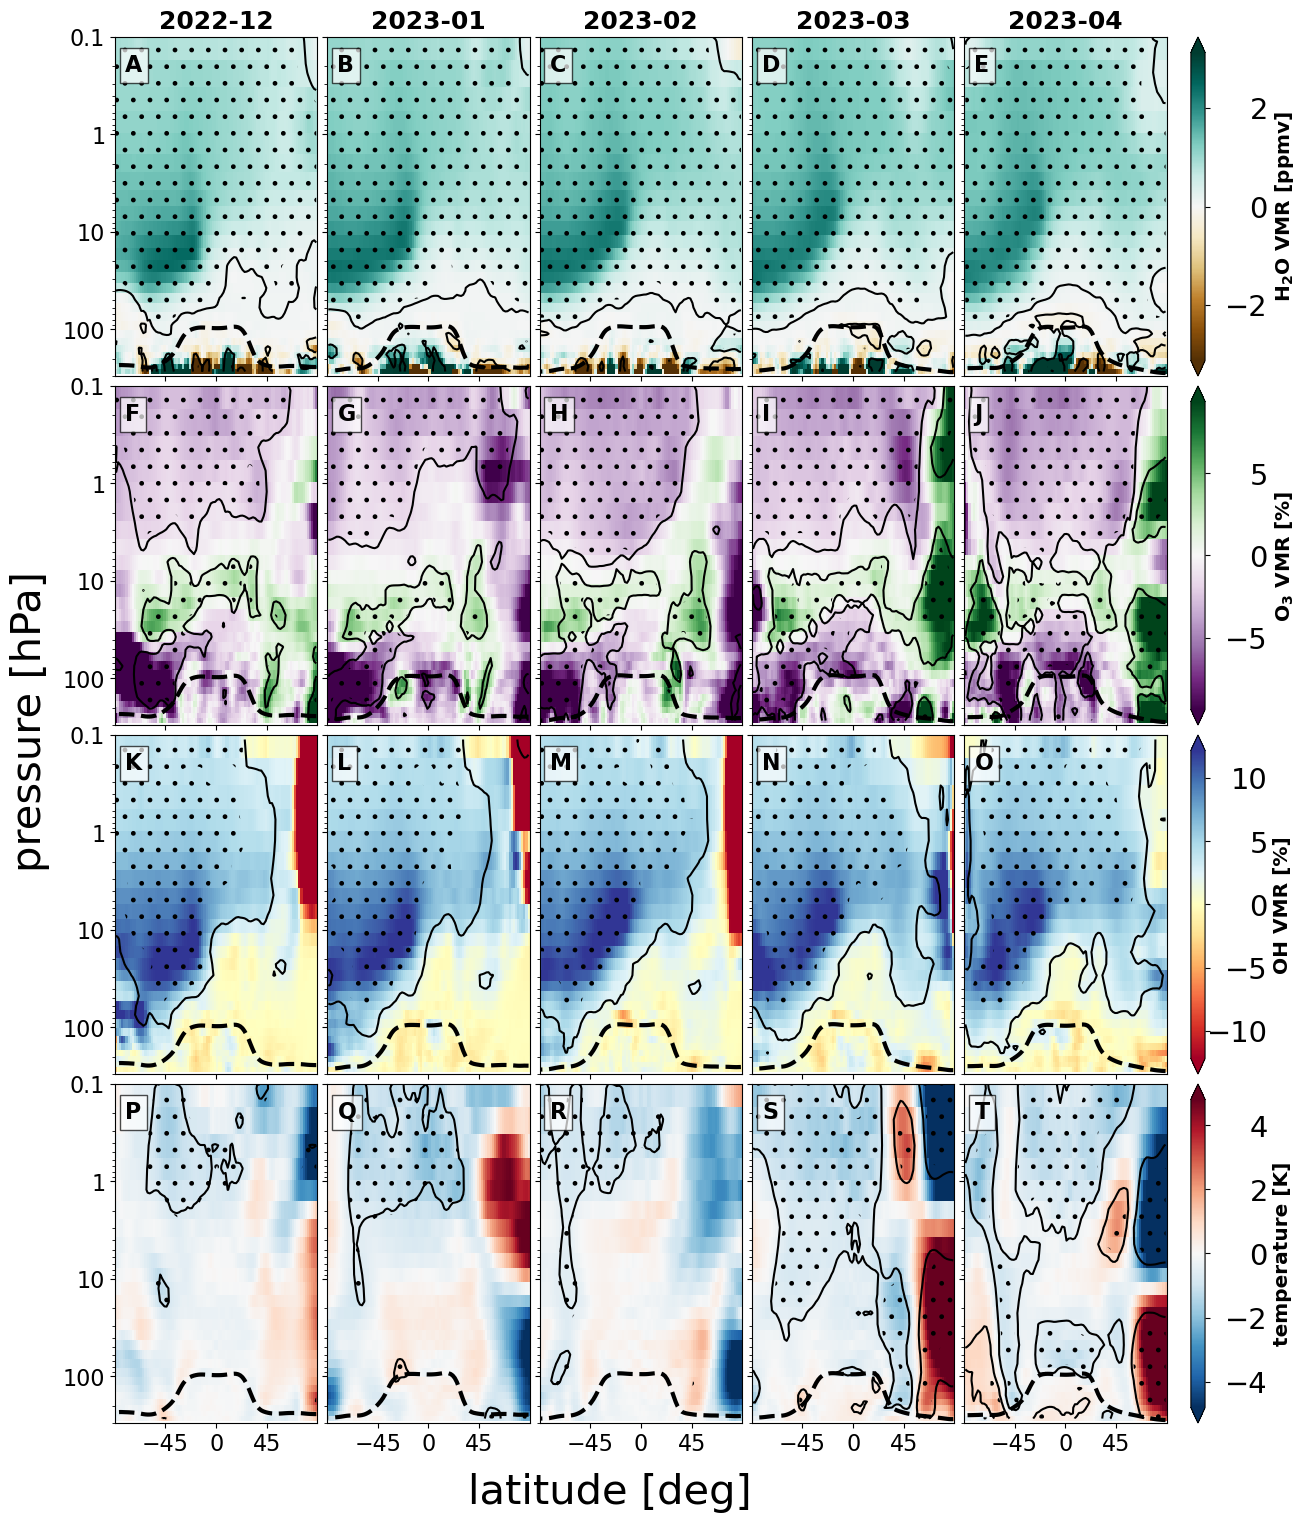

In [233]:
to_pdf = True

fig = plt.figure(figsize=(40, 18))
grid = AxesGrid(
    fig,
    111,  # similar to subplot(122)
    nrows_ncols=(4, 5),
    axes_pad=0.10,
    label_mode="L",
    share_all=True,
    cbar_location="right",
    cbar_mode="edge",
    cbar_size="7%",
    cbar_pad="12%",
    # aspect=True,
)

label = "A"
cmap_ls = ["BrBG", "PRGn", "RdYlBu", "RdBu_r"]
cbar_label_ls = [
    "$\mathrm{\mathbf{H_2O}}$ VMR [ppmv]",
    "$\mathrm{\mathbf{O_3}}$ VMR [%]",
    "OH VMR [%]",
    "temperature [K]",
]
lat = da_w_tpp.lat.values
ROBUST_PERCENTILE = 2
j = 0
l = 0
for i, (axes, data, data_pv, cmap) in enumerate(
    zip(grid.axes_row, data_ls, data_pv_ls, cmap_ls)
):
    # for i, axes in enumerate(grid.axes_row):
    for k, (ax, sel_time) in enumerate(zip(axes, data.time)):
        sel_dict = dict(time=sel_time)

        
        vmax = np.nanpercentile(data, 100 - ROBUST_PERCENTILE)
        kwargs = dict(
            x="lat", yincrease=False,  ax=ax, cmap=cmap, add_colorbar=False,
            vmax = vmax, # robust=True,
        )
        im = data.sel(**sel_dict).plot(**kwargs)
        #print(im.colorbar.vmax)
        """
        kwargs = dict(
            cmap=cmap
        )
        data_sel = data.sel(**sel_dict)
        im = ax.pcolormesh(data_sel.lat.values, data_sel.plev.values, data_sel.values, **kwargs)
        """
        if k == 4:
            # print(k, j, 'asdas')
            cax = grid.cbar_axes[l]
            cb = cax.colorbar(im, extend="both")  # , label = cbar_label_ls[l])
            cb.set_label(label=cbar_label_ls[l], size="xx-small", weight="bold")
            cax.tick_params(labelsize="small")
            # cax.set_label(cbar_label_ls[l])

            for t in cax.get_yticklabels():
                t.set_horizontalalignment("right")
                t.set_x(4.75)

            l += 1
            # fig.colorbar(im, ax=ax)
            # ax.colorbar(im)
            # plt

        kwargs = dict(
            # colors=("k"),
            add_colorbar=False,
            levels=[0, 0.05],
            colors="none",
            hatches=[".", None],
            ax=ax
            # linewidths=np.linspace(1, 4, 4),
        )
        data_pv.sel(**sel_dict).plot.contourf("lat", "plev", **kwargs)

        u_pv = xr_multipletest(data_pv.sel(**sel_dict))[1]
        kwargs = dict(
            colors=("k"),
            add_colorbar=False,
            levels=[0, 0.32],  # 1-sigma
            ax=ax,
            # linewidths=np.linspace(1, 4, 4),
        )
        u_pv.plot.contour("lat", "plev", **kwargs)

        ax.plot(lat, da_w_tpp.sel(**sel_dict), "k--", lw=3)
        # print(sel_time.values, j)

        ax.text(
            0.05,
            0.95,
            ascii_uppercase[j],  # f'{sel_var[:-2]} ({label})',
            transform=ax.transAxes,
            fontsize=16,
            fontweight="bold",
            va="top",
            bbox={"alpha": 0.7, "facecolor": "white"},
        )

        ax.set_ylim(300, 0.1)
        ax.set_yscale("log")
        ax.set_xticks([-45, 0, 45])

        fmt = mpl.ticker.FormatStrFormatter("%g")
        ax.yaxis.set_major_formatter(fmt)

        ax.set_xlabel(None)
        ax.set_ylabel(None)
        # ax.set_aspect(4)

        if i == 0:
            ax.set_title(
                np.datetime_as_string(sel_dict["time"], unit="M"),
                fontsize=18,
                fontweight="bold",
            )
        else:
            ax.set_title(None, fontsize=18)

        j += 1


fig.supxlabel("latitude [deg]", y = 0.06)
fig.supylabel("pressure [hPa]", x=0.35)
outfile = f"time-evolution_2022-2023_diff_mm_zon-htt-new-globally.pdf"
print(outfile)
if to_pdf:
    plt.savefig(outfile, bbox_inches="tight")

In [192]:
im.colorbar.vmax

7.128702239990214

In [174]:
ax.get_aspect()

'auto'